In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from manim import *

In [35]:
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [37]:
def generate_on_line(n, a, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu

    x = scaled_with_offset[:, 0]
    y = scaled_with_offset[:, 1] + a * x

    return x, y

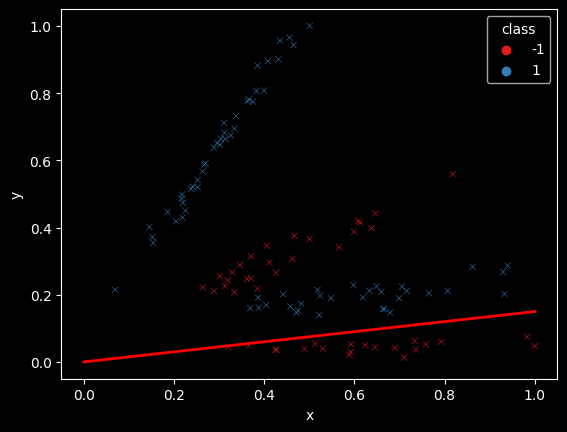

In [454]:
np.random.seed(0)

dependency = [[1.0, 0.0],
              [0.0, 1.0]]

mu = 10, 10
scale = 3, 5

data = {
    'x': [],
    'y': [],
    'class': [],
}

CLASS_A = 1
CLASS_B = -1

# upper A
x, y = generate_on_line(40, 10, dependency, mu, scale)
data['x'].extend(0.5 * x)
data['y'].extend(y)
data['class'].extend([CLASS_A] * len(x))

# lower A
x, y = generate_on_line(30, 2, dependency, mu, scale)
data['x'].extend(x)
data['y'].extend(y)
data['class'].extend([CLASS_A] * len(x))

# upper B
x, y = generate_on_line(25, 5, dependency, mu, scale)
data['x'].extend(0.8 * x)
data['y'].extend(0.95 * y)
data['class'].extend([CLASS_B] * len(x))

# lower B
x, y = generate_on_line(20, .1, dependency, mu, scale)
data['x'].extend(x)
data['y'].extend(0.7 * y)
data['class'].extend([CLASS_B] * len(x))

df = pd.DataFrame(data)
df.x /= df.x.max()
df.y /= df.y.max()


sns.scatterplot(data=df, x='x', y='y',
                hue='class', s=20,
                marker='x', palette='Set1')

x = np.linspace(0, 1)
plt.plot(x, .15 * x, color='red', linewidth=2)

plt.show()

In [471]:
import torch

class LinearModelNoBias(torch.nn.Module):

     def __init__(self, input_dim, output_dim):
        super(LinearModelNoBias, self).__init__()
        self.weight = torch.nn.Parameter(torch.empty((input_dim, output_dim)))

     def forward(self, x):
         return self.weight * x
     
model = LinearModelNoBias(1, 1)
training_X = torch.tensor(df.x.to_numpy())
training_Y = torch.tensor(df.y.to_numpy())
training_targets = torch.tensor(df['class'].to_numpy())

mse = torch.nn.MSELoss()

def loss(model, x, y, targets):
    k = 5  
    # parameter to control scale and highlight local minima
    # high k gives more weight to close classifications  
    return mse(torch.tanh(k * (y - model(x))).squeeze(), targets)


class LossLandscape:

    def __call__(self, w):
        model.load_state_dict({'weight': torch.tensor([[w]])})
        return loss(model, training_X, training_Y, training_targets).detach().numpy()

In [469]:
class SGDLossLandscape:

    def __init__(self, random_state=None):
        MINI_BATCH_SIZE = df.index.size // 2
        self.mini_df = df.sample(MINI_BATCH_SIZE, random_state=random_state)

    def __call__(self, w):
        training_mini_X = torch.tensor(self.mini_df.x.to_numpy())
        training_mini_Y = torch.tensor(self.mini_df.y.to_numpy())
        training_mini_targets = torch.tensor(self.mini_df['class'].to_numpy())
        model.load_state_dict({'weight': torch.tensor([[w]])})
        return loss(model, training_mini_X, training_mini_Y, training_mini_targets).detach().numpy()

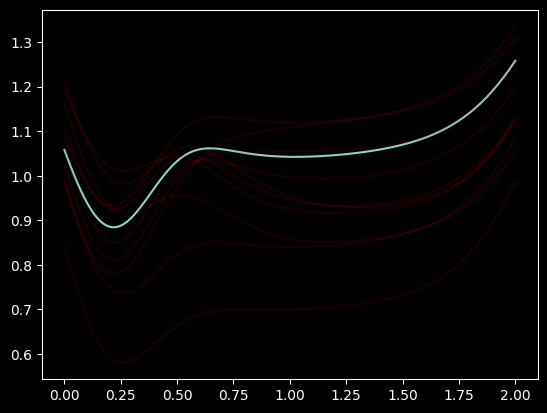

In [472]:
w = np.linspace(0, 2, 1000)
loss_landscape = np.vectorize(LossLandscape())

plt.plot(w, loss_landscape(w))
for _ in range(10):
    sgd_loss_landscape = np.vectorize(SGDLossLandscape())
    plt.plot(w, sgd_loss_landscape(w), alpha=0.1, c='red')

In [524]:
%%manim -ql -n 12 Animations


def lerp_fns(f1, f2, t):
    return np.vectorize(lambda x: (1 - t) * f1(x) + t * f2(x))


class Animations(Scene):

    def create_scatter_point(self, row):
        row_idx, data_point = row
        colour = self.get_colour(row)
        if colour == GREY:
            opacity = 0.25
        else:
            opacity = 1.0

        if data_point['class'] == 1:
            marker = Dot(color=colour, radius=self.marker_size, fill_opacity=opacity)
        else:
            dot = Dot(color=RED, radius=self.marker_size)
            marker = Cross(mobject=dot, color=colour, stroke_color=colour, 
                           stroke_width=self.marker_size * 50, stroke_opacity=opacity)
        
        marker.move_to(self.data_axes.coords_to_point(data_point.x, data_point.y))

        return marker

    def get_colour(self, row, t):
        row_idx, data_point = row

        t = self.t.get_value();
        if t > 0:
            loss_fn = self.next_loss_fn
        else:
            loss_fn = self.curr_loss_fn

        if data_point['class'] == 1:
            colour = RED
        else:
            colour = BLUE
        
        is_deactive = isinstance(loss_fn.pyfunc, SGDLossLandscape) \
            and row_idx not in loss_fn.pyfunc.mini_df.index

        if is_deactive:
            return rgb_to_color(t * color_to_rgb(GREY) + (1 - t) * color_to_rgb(colour))
        
        return colour

    def iterate_loss_fns(self):  
        self.loss_counter += 1
        self.curr_loss_fn = self.next_loss_fn
        self.next_loss_fn = np.vectorize(SGDLossLandscape(random_state=self.loss_counter))
        df['colour'] = [self.get_colour(row) for row in df.iterrows()]

    def construct(self):
        self.loss_counter = 0
        self.marker_size = 0.04

        self.curr_loss_fn = np.vectorize(LossLandscape())
        self.next_loss_fn = np.vectorize(SGDLossLandscape(random_state=self.loss_counter))
        self.t = ValueTracker(0)


        # 2D axes on unit square
        self.data_axes = Axes(
            x_range=[0, 1, 0.1],
            y_range=[0, 1, 0.1],
            axis_config={"include_tip": False},
            x_axis_config={"numbers_to_include": [0, 1]},
            y_axis_config={"numbers_to_include": [0, 1]},
            x_length=6,
            y_length=6,
        )

        # scatter data

        # df['colour'] = [RED if c == 1 else BLUE for c in data['class']]
        
        data_group = always_redraw(lambda: VGroup(*[
            self.create_scatter_point(row)
            for row in df.iterrows()
        ]))

        self.play(Create(self.data_axes), Create(data_group))

        self.wait(1)

        w = ValueTracker(1.0)
        graph = always_redraw(
            lambda: self.data_axes.plot(
                np.vectorize(lambda x: w.get_value() * x),
                x_range=[0, min(1, 1 / w.get_value()), 0.1],
                color=YELLOW, use_vectorized=True)
        )
        self.play(Create(graph))

        self.play(w.animate.set_value(0.5), run_time=2)

        self.wait(1)

        
        self.loss_axes = Axes(
            x_range=[0, 2, 0.1],
            y_range=[0.5, 1.5],#[.85, 1.3, 0.1],
            axis_config={"include_tip": False},
            x_axis_config={"numbers_to_include": [0, 2]},
            # y_axis_config={"numbers_to_include": [0.85, 1.3]},
            x_length=6,
            y_length=6,
        )
        self.loss_axes.to_corner(RIGHT)
        
        loss_graph = always_redraw(lambda: self.loss_axes.plot(
            lerp_fns(self.curr_loss_fn, self.next_loss_fn, self.t.get_value()),
            color=ORANGE, x_range=[0, 2], use_vectorized=True
        ))

        self.play(self.data_axes.animate.to_corner(LEFT))
        self.play(Create(self.loss_axes),
                  Create(loss_graph, lag_ratio=.5))

        self.wait(1)

        w_dot = always_redraw(
            lambda: Dot(
                self.loss_axes.coords_to_point(
                    w.get_value(), 
                    lerp_fns(self.curr_loss_fn, self.next_loss_fn, self.t.get_value())(w.get_value())),
                color=YELLOW)
        )

        self.play(Create(w_dot))
        self.play(w.animate.set_value(0), run_time=2)
        self.play(w.animate.set_value(2), run_time=2)


        original_loss_graph = self.loss_axes.plot(
            self.curr_loss_fn, color=RED,  x_range=[0, 2], use_vectorized=True, stroke_opacity=0.5
        )
        
        # df['colour'] = [self.get_colour(row) for row in df.iterrows()]

        self.wait(1)
        self.play(FadeIn(original_loss_graph), self.t.animate.set_value(1), run_time=1)

        for _ in range(6):
            self.wait(1)
            self.iterate_loss_fns()
            self.t.set_value(0)
            self.play(self.t.animate.set_value(1), run_time=1)


[01/18/23 16:54:27] INFO     No end scene number specified in -n option. Rendering from 12 onwards...  ]8;id=986105;file://C:\tools\Manim\Lib\site-packages\manim\_config\utils.py\utils.py]8;;\:]8;id=62470;file://C:\tools\Manim\Lib\site-packages\manim\_config\utils.py#789\789]8;;\

C:\tools\Manim\Lib\site-packages\manim\mobject\types\vectorized_mobject.py:125: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  super().__init__(**kwargs)
Animation 9: _MethodAnimation(ValueTracker):   0%|          | 0/1 [00:00<?, ?it/s]                 <string>:94: RuntimeWarning: divide by zero encountered in scalar divide


[01/18/23 16:54:35] INFO     Animation 12 : Partial movie file written in                  ]8;id=692592;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=450482;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_2312901173_3787826303.mp4'                                       

[01/18/23 16:54:36] INFO     Animation 13 : Partial movie file written in                  ]8;id=592406;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=667782;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1380718205_345352296_2175501382.mp4'                                        

[01/18/23 16:54:42] INFO     Animation 14 : Partial movie file written in                  ]8;id=222164;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=2583;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_3138776337_2749436582.mp4'                                       

                    INFO     Animation 15 : Partial movie file written in                  ]8;id=985822;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=411068;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1380718205_345352296_733152413.mp4'                                         

[01/18/23 16:54:48] INFO     Animation 16 : Partial movie file written in                  ]8;id=307648;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=788264;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_3138776337_96762192.mp4'                                         

                    INFO     Animation 17 : Partial movie file written in                  ]8;id=333151;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=868090;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_345352296_2757234235.mp4'                                        

[01/18/23 16:54:54] INFO     Animation 18 : Partial movie file written in                  ]8;id=269618;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=683517;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_3138776337_616023164.mp4'                                        

                    INFO     Animation 19 : Partial movie file written in                  ]8;id=647648;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=319507;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_345352296_2610252174.mp4'                                        

[01/18/23 16:55:00] INFO     Animation 20 : Partial movie file written in                  ]8;id=706797;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=787506;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_3138776337_1246288242.mp4'                                       

[01/18/23 16:55:01] INFO     Animation 21 : Partial movie file written in                  ]8;id=739674;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=236491;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_345352296_4107627390.mp4'                                        

[01/18/23 16:55:07] INFO     Animation 22 : Partial movie file written in                  ]8;id=859491;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=694255;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_3138776337_2137911928.mp4'                                       

                    INFO     Animation 23 : Partial movie file written in                  ]8;id=508532;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=781875;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_345352296_1615256634.mp4'                                        

[01/18/23 16:55:13] INFO     Animation 24 : Partial movie file written in                  ]8;id=59757;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=601832;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\Gradient                                               
                             Descent\manim\media\videos\manim\480p15\partial_movie_files\A                         
                             nimations\1442284246_3138776337_613479821.mp4'                                        

                    INFO     Combining to Movie file.                                      ]8;id=395756;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=414623;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#617\617]8;;\

                    INFO                                                                   ]8;id=684660;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=448888;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#736\736]8;;\
                             File ready at 'C:\Users\dylan\OneDrive\Video\Gradient                                 
                             Descent\manim\media\videos\manim\480p15\Animations.mp4'                               
                                                                                                                   

                    INFO     The partial movie directory is full (> 100 files). Therefore, ]8;id=716017;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=182867;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#708\708]8;;\
                             manim has removed the 13 oldest file(s). You can change this                          
                             behaviour by changing max_files_cached in config.                                     

                    INFO     Rendered Animations                                                       ]8;id=375586;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene.py\scene.py]8;;\:]8;id=624434;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene.py#241\241]8;;\
                             Played 25 animations                                                                  

In [ ]:
rgb_to_color

In [521]:
color_to_rgb

<function manim.utils.color.color_to_rgb(color: 'Color | str') -> 'np.ndarray'>